In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

def calcular_flujos(valor_nominal, tasa_cup, periodo_cupon, tasa_interes, dias_vencimiento):
    #Declaración de Variables unidimensionales
    cupones_vencer = dias_vencimiento / periodo_cupon
    periodos = math.ceil(cupones_vencer)
    dias_devengados = (math.ceil(dias_vencimiento / periodo_cupon) - cupones_vencer) * periodo_cupon
    dias_vencer_cc = periodo_cupon - dias_devengados

    # Inicialización de arrays
    dias_flujo = np.zeros(periodos)
    cupones = np.zeros(periodos)
    indice = np.zeros(periodos)
    valor_nominal_flujo = np.zeros(periodos)
    valor_presente = np.zeros(periodos)

    #Asignación de valores correspondientes a un Bono Bullet y proporción de interés devengado
    valor_nominal_flujo[-1] = valor_nominal
    dias_flujo[0] = dias_vencer_cc
    cupones[0] = valor_nominal * tasa_cup * periodo_cupon / 360
    
    #Identificar si ha transcurrido o no días devengados   
    if cupones_vencer % 1 == 0:
        indice[0] = 1
    else:
        indice[0] = 0

    #Ajustar los cupones y días del flujo acorde a si hay o no interés devengado   
    for t in range(1, periodos):
        dias_flujo[t] = dias_vencer_cc + periodo_cupon * t
        cupones[t] = valor_nominal * tasa_cup * periodo_cupon / 360
        indice[t] = 1 + indice[t - 1]

    flujo_efectivo = cupones + valor_nominal_flujo
    for t in range(periodos):
        valor_presente[t] = flujo_efectivo[t] / ((1 + tasa_interes * periodo_cupon / 360) ** (dias_flujo[t] / periodo_cupon))

    return dias_flujo, cupones, indice, valor_nominal_flujo, valor_presente

def calendario_pagos(valor_nominal, tasa_cup, periodo_cupon, tasa_interes, dias_vencimiento):
    dias_flujo, cupones, indice, valor_nominal_flujo, valor_presente = calcular_flujos(valor_nominal, tasa_cup, periodo_cupon, tasa_interes, dias_vencimiento)
    precio_sucio = valor_presente.sum()
    proporcion = valor_presente / precio_sucio
    tiempo_proporcion = proporcion * (dias_flujo / periodo_cupon)

    df = {'Indice': indice,
          'Dias Flujo': dias_flujo,
          'Cupón': cupones,
          'Valor Nominal': valor_nominal_flujo,
          'Flujo Efectivo': cupones + valor_nominal_flujo,
          'Valor Presente': valor_presente,
          'Proporción': proporcion,
          'Tiempo x Proporción': tiempo_proporcion}

    calendario_pagos = pd.DataFrame(df)
    calendario_pagos.loc['Suma'] = ['Total', "", cupones.sum(), "", "", valor_presente.sum(), proporcion.sum(), tiempo_proporcion.sum() * periodo_cupon / 360]
    calendario_pagos.set_index('Indice', inplace=True)

    return calendario_pagos

def medidas_bono(valor_nominal, tasa_cup, periodo_cupon, tasa_interes, dias_vencimiento):
    dias_flujo, cupones, indice, valor_nominal_flujo, valor_presente = calcular_flujos(valor_nominal, tasa_cup, periodo_cupon, tasa_interes, dias_vencimiento)
    precio_sucio = valor_presente.sum()
    dias_devengados = (math.ceil(dias_vencimiento / periodo_cupon) - dias_vencimiento / periodo_cupon) * periodo_cupon
    interes_devengado = valor_nominal * tasa_cup * dias_devengados / 360
    precio_limpio = precio_sucio - interes_devengado
    proporcion = valor_presente / precio_sucio
    tiempo_proporcion = proporcion * (dias_flujo / periodo_cupon)
    duracion_macaulay = tiempo_proporcion.sum() * periodo_cupon / 360
    duracion_modificada = duracion_macaulay / (1 + tasa_interes * periodo_cupon / 360)
    interes_bruto = cupones.sum() - interes_devengado

    datos = {'Concepto': ['Precio Sucio', 'Interés Devengado', 'Precio Limpio', 'Duración Macaulay', 'Duración Modificada', 'Interés Bruto'],
             'Dato': [precio_sucio, interes_devengado, precio_limpio, duracion_macaulay, duracion_modificada, interes_bruto]}

    medidas = pd.DataFrame(datos)
    medidas.set_index('Concepto', inplace=True)

    return medidas


def grafica_bono_m(valor_nominal,tasa_cup, periodo_cupon, tasa_interes, dias_vencimiento,min,max,escenarios):
    cupones_vencer=dias_vencimiento/periodo_cupon
    cupones_vigentes=math.ceil(cupones_vencer)
    tasa_interes_potencial = np.linspace(min, max, escenarios)
    precio_sucio = np.zeros(escenarios)
    cupon = valor_nominal*tasa_cup*periodo_cupon/360
    cupones_vencer=dias_vencimiento/periodo_cupon
    dias_devengados=(math.ceil(dias_vencimiento/periodo_cupon)-cupones_vencer)*periodo_cupon
    tasa_ajustada_actual = tasa_interes*periodo_cupon/360

    precio = np.zeros(escenarios)
    precio_0= (cupon+cupon*((1/tasa_ajustada_actual)-(1/(tasa_ajustada_actual*(1+tasa_ajustada_actual)**(cupones_vigentes-1))))+valor_nominal/(1+tasa_ajustada_actual)**(cupones_vigentes-1))/(1+tasa_ajustada_actual)**(1-dias_devengados/periodo_cupon)
    print(precio_0)
    for idx, i in enumerate(tasa_interes_potencial):
        tasa_ajustada = i * periodo_cupon / 360
        precio_sucio[idx] = (cupon + cupon * ((1 / tasa_ajustada) - (1 / (tasa_ajustada * (1 + tasa_ajustada) ** (cupones_vigentes - 1)))) + valor_nominal / (1 + tasa_ajustada) ** (cupones_vigentes - 1)) / (1 + tasa_ajustada) ** (1 - dias_devengados / periodo_cupon)

    plt.plot(tasa_interes_potencial, precio_sucio, label='Precio Sucio')
    plt.scatter([tasa_interes], [precio_0], color='red', label='Precio Actual')  # Punto para el precio actual
    plt.annotate(f'Precio Actual: {precio_0:.2f}', (tasa_interes, precio_0), textcoords="offset points", xytext=(10,-10), ha='center')

    plt.xlabel('Tasa de Interés')
    plt.ylabel('Precio Sucio del Bono')
    plt.title('Precio Sucio del Bono vs Tasa de Interés')
    plt.legend()
    plt.show()


,Dias Flujo,Cupón,Valor Nominal,Flujo Efectivo,Valor Presente,Proporción,Tiempo x Proporción
Indice,,,,,,,
0.0,123.0,3.0,0.0,3.0,2.940012,0.029126,0.019903
1.0,303.0,3.0,0.0,3.0,2.854381,0.028278,0.047601
2.0,483.0,3.0,0.0,3.0,2.771244,0.027454,0.073669
3.0,663.0,3.0,0.0,3.0,2.690528,0.026655,0.098178
4.0,843.0,3.0,0.0,3.0,2.612163,0.025878,0.121197
5.0,1023.0,3.0,0.0,3.0,2.536080,0.025125,0.142791
6.0,1203.0,3.0,0.0,3.0,2.462214,0.024393,0.163025
7.0,1383.0,3.0,0.0,3.0,2.390499,0.023682,0.181959
8.0,1563.0,3.0,0.0,3.0,2.320873,0.022993,0.199652


,Dato
Concepto,
Precio Sucio,100.940423
Interés Devengado,0.950000
Precio Limpio,99.990423
Duración Macaulay,6.310634
Duración Modificada,6.126829
Interés Bruto,47.050000


100.94042318703882


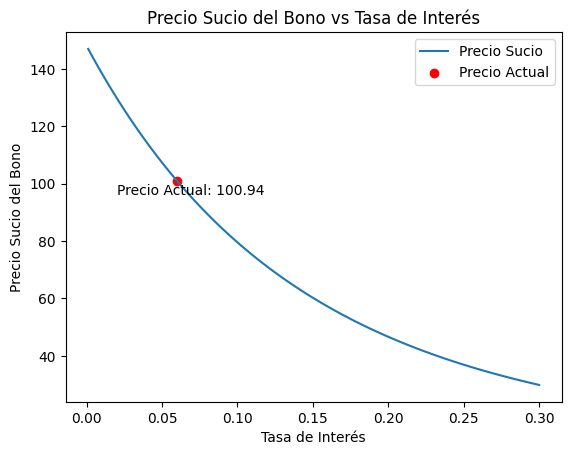

In [3]:
#Ejemplo3
vn=100
tcup=0.06
per=180
ytm=0.06
dias_ven = 2823
min = 0.001
max = 0.30
esce = 100

calendario = calendario_pagos(vn,tcup,per,ytm,dias_ven)
display(calendario)
medidas = medidas_bono(vn,tcup,per,ytm,dias_ven)
display(medidas)
grafica_bono_m(vn,tcup,per,ytm,dias_ven,min,max,esce)